# Anomaly Detection

This notebook analyzes a dataset on household electricity usage.

## Data explanation

The data is split into 9 columns;

* **Date**: Date in format dd/mm/yyyy
* **Time**: Time in format hh:mm:ss
* **Global_active_power**: Household global minute-averaged active power (in kilowatts)
* **Global_reactive_power: Household global minute-averaged reactive power (in kilowatts)
* **Voltage**: Minute-averaged voltage (in volts)
* **Global_intensity**: Household global minute-averaged current intensity (in ampere)
* **Sub_metering_1**: Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
* **Sub_metering_2**: Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a regrigerator and a light.
* **Sub_metering_3**: Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


## Import libraries and Set Global Functions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown, display

## Load the data sets
Heads up: The Date_Time parsing takes a while.

In [2]:
# To print Markdown from within Python 3 code.
def printmd(string):
    display(Markdown(string))

data_sets_paths = os.listdir('tests')
data_sets = dict()
for data_set_path in data_sets_paths:
    data_sets[os.path.basename(os.path.splitext(data_set_path)[0])] = pd.read_csv(os.path.join('tests', data_set_path),
                                           #parse_dates=[['Date', 'Time']]
                                          ) 

## Remove null values in data

In [3]:
#data.isnull().sum() #print nulls
#data = data.dropna();
#data.isnull().sum()
print("Not cleaning the dataset - Turns out we need the rows that have null fields because they contain interesting data.")

Not cleaning the dataset - Turns out we need the rows that have null fields because they contain interesting data.


# Phase 1. General data exploration

## Characteristic 1: Checking for overall changes relative to the expected normal behaviour

For instance, consider checking the test data against the original data with respect to various characteristic features for certain specified time windows (such as Friday nights etc.) over a longer time period, say about a year. A fairly basic check could be done by calculating and comparing the mean and standard deviation. 

In [4]:
# Characteristic 1
is_first = True
for data_set_path in data_sets:
    if is_first:
        is_first = False
    else:
        printmd('<br>')
    printmd('<h4>Test Data for \"{}\"</h4>'.format(data_set_path))
    display(data_sets[data_set_path].describe())

<h4>Test Data for "train"</h4>

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.556420e+06,1.548096e+06,1.548096e+06,1.548096e+06,1.548096e+06,1.548096e+06,1.548096e+06
mean,1.227081e+00,1.218398e-01,2.405477e+02,4.642235e+00,1.156032e+00,1.358988e+00,6.166653e+00
std,1.055740e+00,1.116522e-01,3.261095e+00,4.579198e+00,6.275350e+00,6.023466e+00,8.315138e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.541500e-01,4.600000e-02,2.386700e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.200000e-01,1.000000e-01,2.407800e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.696200e+00,1.920000e-01,2.426700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.539400e+02,4.840000e+01,8.200000e+01,7.800000e+01,3.100000e+01


<br>

<h4>Test Data for "unofficial-test"</h4>

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,518816.000000,501185.000000,501185.000000,501185.000000,501185.000000,501185.000000,501185.000000
mean,1.218208,0.129505,241.742351,4.583042,1.016565,1.111739,7.359761
std,0.905431,0.115773,2.999253,3.999089,5.757542,5.145805,8.742083
min,0.138000,0.000000,225.320000,0.600000,0.000000,0.000000,0.000000
25%,0.544350,0.054000,239.900000,1.400000,0.000000,0.000000,1.000000
50%,1.008100,0.102000,241.650000,3.200000,0.000000,0.000000,1.000000
75%,1.689250,0.200000,243.520000,6.400000,0.000000,1.000000,18.000000
max,9.724000,1.186000,254.150000,43.000000,88.000000,80.000000,31.000000


## Characteristic 2: Understanding feature correlation

Considering the various features such as “Global_active_power” and “Global_intensity” that collectively form a multivariate time series and their respective correlation coefficients, how meaningful is it to include all of these features in the data analysis? What can be simplified?

In [5]:
# Characteristic 2

# Phase 2. Anomaly detection approach

## Approach 1: Finding Point Anomalies

### (I) Out of Range

Based on the Min and Max values of a certain feature in a specific time window over the training dataset, one can detect all those values (of the same feature) in the test dataset which are either above or are under the Max-Min range (i.e., point anomalies or outliers)

In [6]:
# Out of range (Min/Max) on time slice


### (II) Moving Average

* Step 1: Consider a fixed size window of observations (e.g., a window of 7 observations).

* Step 2: For a specific feature, calculate the average of the window and then slide the window by one observation. (This will eventually smoothen the curve of that feature.)      

* Step 3: At any point of Step 2, if the difference of the value of the observation and the calculated average is either above or below a certain threshold, that observation can be considered a point anomaly of the feature in question.

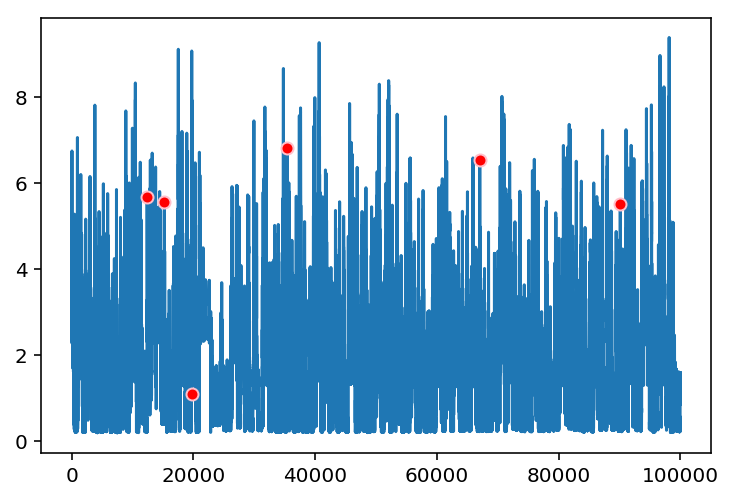

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Step 1: Set window size
part2data = data_sets["train"]
feature_name = 'Global_active_power'
start_row = 0
end_row   = 100000
window_size = 7
threshold_max = 4
threshold_min = -4

# Step 2: Get moving average of feature

feature = part2data[feature_name]
feature = feature[start_row:end_row]
#feature = feature.dropna()

moving_average = feature.rolling(window_size, center=False).mean()

# Step 3: 

difference = pd.DataFrame(feature - moving_average)

over_max = difference[feature_name] > threshold_max
under_min = difference[feature_name] < threshold_min

outliers = difference[under_min | over_max]

feature.plot(marker='o',
                    markerfacecolor='red',
                    markeredgecolor='pink',
                    markevery=outliers.index.tolist())

## TO:DO add subplot showing moving average line over this?

## Approach 2: Building HMMs and calculating log-likelihood (contextual anomalies)

* Step 1: Choose a feature combination for training multivariate HMMs or provide a rational for selecting only a single feature for training univariate HMMs.
* Step 2: Partition complex datasets into smaller subsets by defining various time windows, each representing a regular pattern for a different window size and/or different time period.
* Step 3: Train one HMM for each time window using a suitable R package.
* Step 4: Calculate the log-likelihood of an observation, given the HMM by means of the respective R package.
* Step 5: Find the best HMM for each time window using cross-validation by partitioning the original data into training data and validation data (exclude the test data here!).
* Step 6: Detect anomalies by comparing the log-likelihood of the training data and the test data.
* Step 7: Fine-tune the balance between recall and precision and explain the rational for your final choice based on the calculated F-measure(s) or balanced F-score(s).

In [2]:
# HMM

# Filter by weekend
# e.g. weekends = filter_weekend("tests/train.txt", 30000)
def filter_weekend(csv_path, num_rows):
    # Get raw data (cannot be a copy)
    weekend = pd.read_csv(csv_path)

    if num_rows > 0:
        # Get only first n rows
        weekend = weekend[:num_rows]

    # Convert date column to python datetime object
    weekend['Date'] = pd.to_datetime(weekend['Date'])

    # Create new column from Date: weekday number
    weekend['weekday'] = weekend['Date'].apply(lambda x: x.weekday())
    # Create new column from Date: weekday name
    weekend['weekday_name'] = weekend['Date'].apply(lambda x: x.weekday_name)

    # Filter by weekday >= 4
    weekend = weekend[weekend['weekday'] >= 4]
    return weekend

# Filter by specific day
# weekday_name must have first letter capitalized e.g. "Friday" or "Wednesday"
# e.g. fridays = filter_specific_day("tests/train.txt", 30000, "Friday")
def filter_specific_day(csv_path, num_rows, weekday_name):
    # Get raw data (cannot be a copy)
    day = pd.read_csv(csv_path)
    
    if num_rows > 0:
        # Get only first n rows
        day = day[:num_rows]

    # Convert date column to python datetime object
    day['Date'] = pd.to_datetime(day['Date'])

    # Create new column from Date: weekday number
    day['weekday'] = day['Date'].apply(lambda x: x.weekday())
    # Create new column from Date: weekday name
    day['weekday_name'] = day['Date'].apply(lambda x: x.weekday_name)

    # Filter by weekday_name
    day = day[day['weekday_name'] == weekday_name]
    return day


In [28]:
from pomegranate import *

print("Splitting data into only Fridays")

all_fridays = filter_specific_day("tests/train.txt", 0, "Friday")

all_fridays = all_fridays.drop(columns=['Global_reactive_power', 'Date', 'Time', 'weekday', 'weekday_name'])

all_fridays = all_fridays.values




Splitting data into only Fridays


In [31]:
print("Training HMM")
model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, #NormalDistribution,
                                       n_components=2,
                                       X=all_fridays,
                                       algorithm="baum-welch",
                                       min_iterations=30,
                                       n_jobs=8)

Training HMM


/home/timr/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Install pygraphviz for nicer visualizations
  """Entry point for launching an IPython kernel.
/home/timr/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/timr/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/timr/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/timr/miniconda3/lib/python3.6/site-packages/networkx/dra

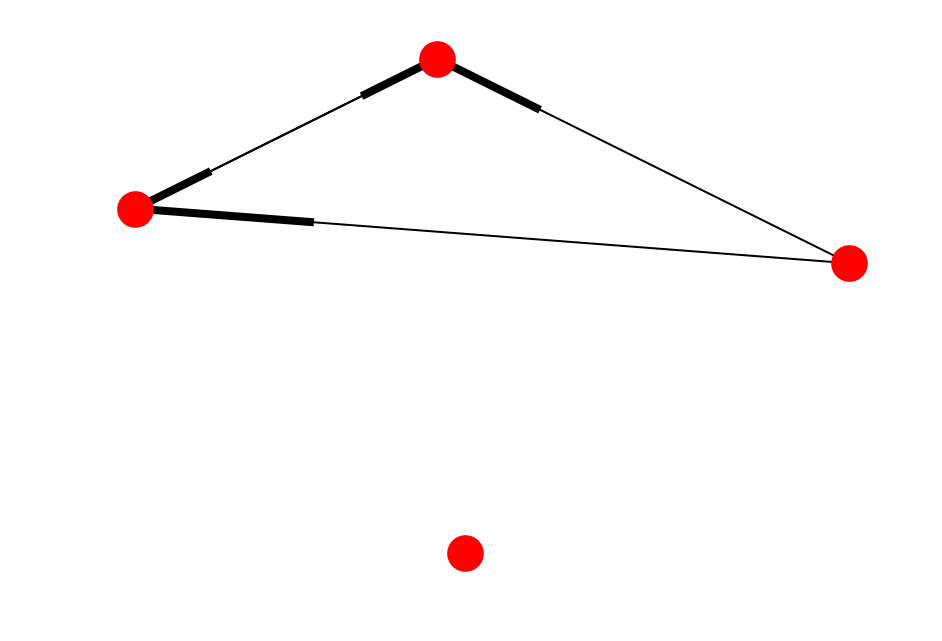

In [32]:
model.plot()

In [33]:
model.state_count()

4

In [11]:
fridays_data

array([[5.10600e-01, 2.45700e+02, 8.00000e-01, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.06000e-01, 2.46180e+02, 8.00000e-01, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [3.28000e-01, 2.45610e+02, 1.40000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       ...,
       [2.47600e+00, 2.41060e+02, 1.02000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.61695e+00, 2.41660e+02, 7.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.57560e+00, 2.43000e+02, 1.40000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00]])

In [12]:
fridays_test = filter_specific_day("tests/train.txt", 20000, "Friday")

fridays_test = fridays_test[1500:]

fridays_test = fridays_test.drop(columns=['Global_reactive_power', 'Date', 'Time', 'weekday', 'weekday_name'])

#test
#fridays_test = fridays_test.drop(columns=['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_intensity'])


fridays_test_data = fridays_test.values #= np.array(fridays_test)


model.log_probability(fridays_test_data[1])
#fridays_test_data

-20.02422612949503

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [20]:

# train
model.fit(all_fridays, algorithm="baum-welch", )

136531.7173729008

In [14]:
len(fridays_data)

1440

In [35]:
model.log_probability(fridays_data) / len(fridays_data)

-3.073655665423981

In [34]:
model.log_probability(fridays_data[100])

-18.997288609318616

### Interesting point in time (January 1)
Global active power drops at 14:00 on January 1

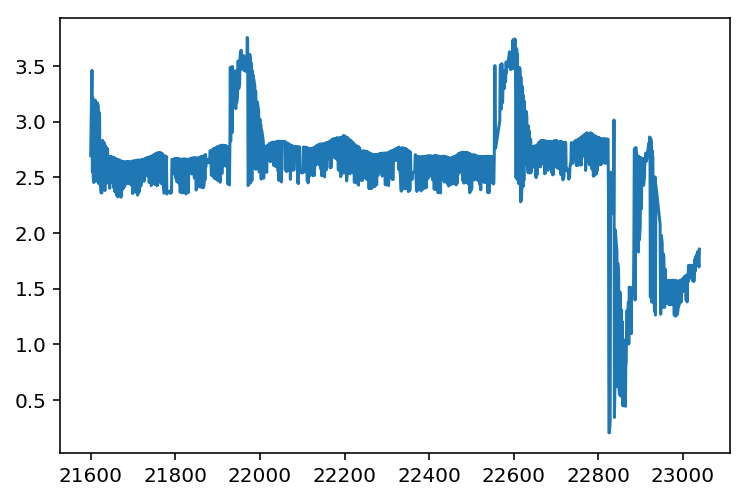

In [58]:
data_sets['train']['Global_active_power'][15*24*60:16*24*60].plot(x='Date_Time', y='Global_active_power')

### Interesting point in time (December 31)
Global active power is erratic in the night on December 31

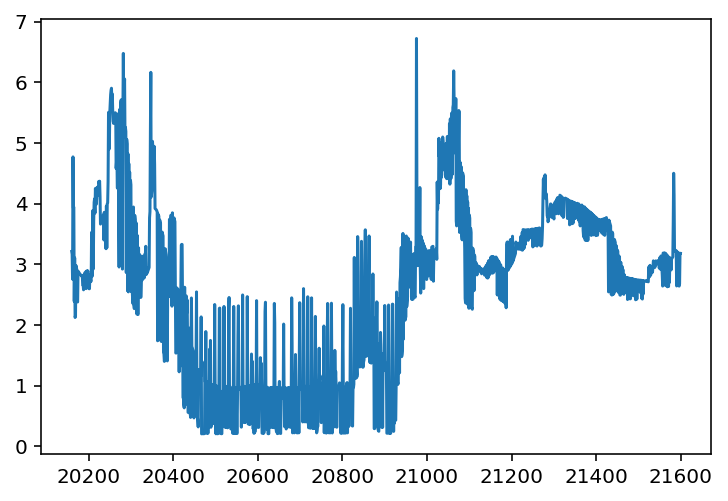

In [59]:
data_sets['train']['Global_active_power'][14*24*60:15*24*60].plot(x='Date_Time', y='Global_active_power')

In [60]:
data_sets['train'].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.556420e+06,1.548096e+06,1.548096e+06,1.548096e+06,1.548096e+06,1.548096e+06,1.548096e+06
mean,1.227081e+00,1.218398e-01,2.405477e+02,4.642235e+00,1.156032e+00,1.358988e+00,6.166653e+00
std,1.055740e+00,1.116522e-01,3.261095e+00,4.579198e+00,6.275350e+00,6.023466e+00,8.315138e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.541500e-01,4.600000e-02,2.386700e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.200000e-01,1.000000e-01,2.407800e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.696200e+00,1.920000e-01,2.426700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.539400e+02,4.840000e+01,8.200000e+01,7.800000e+01,3.100000e+01
